In [1]:
from data_processing import process_mat_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_extreme import ClimateExtreme
import climate_stats as cs
import scipy.stats as stats

from BucketModel import BucketModel, BucketModelOptimizer
from BucketModel.data_processing import preprocess_data
from BucketModel.bucket_model_plotter import *

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm


from generate_future_climate import generate_future_climate

import warnings
warnings.filterwarnings("ignore")

## (WEEK 1) Simulating ensembles with the WeaGETS weather generator.
### Reading in the input data and the output files from WeaGETS

In [2]:
input_data_path = "/Users/cooper/Desktop/climate-impacts/data/Input_data.mat"
path_exp_first = '/Users/cooper/Desktop/climate-impacts/data/Exponential/Seperated_FirstOrder_Exp_1500(30).mat'

present_data = process_mat_file(input_data_path)
exp_first_data = process_mat_file(path_exp_first)

In [3]:
present_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day
0,0.4,1.5,-10.1,-4.30,1986,Jan,1
1,5.9,4.1,-2.0,1.05,1986,Jan,2
2,0.0,4.1,-3.1,0.50,1986,Jan,3
3,7.8,-0.3,-11.7,-6.00,1986,Jan,4
4,0.0,1.4,-10.1,-4.35,1986,Jan,5
...,...,...,...,...,...,...,...
12405,13.7,3.4,-1.1,1.15,2019,Dec,27
12406,0.4,2.2,-3.6,-0.70,2019,Dec,28
12407,0.0,5.7,-3.2,1.25,2019,Dec,29
12408,0.0,7.8,1.1,4.45,2019,Dec,30


In [4]:
exp_first_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day,Simulation
0,1.052159,0.575836,-3.966348,-1.695256,1980,Jan,1,1
1,2.840043,2.131566,-2.196253,-0.032343,1980,Jan,2,1
2,0.000000,0.337740,-2.734396,-1.198328,1980,Jan,3,1
3,0.000000,4.614041,0.185355,2.399698,1980,Jan,4,1
4,2.044771,2.277004,-3.072299,-0.397647,1980,Jan,5,1
...,...,...,...,...,...,...,...,...
547495,13.138856,-2.289081,-9.061114,-5.675098,2009,Dec,27,50
547496,7.726682,-2.705927,-8.001282,-5.353604,2009,Dec,28,50
547497,5.920434,-0.570781,-7.474422,-4.022602,2009,Dec,29,50
547498,0.000000,1.047279,-5.964266,-2.458494,2009,Dec,30,50


## Looking at climate statistics to compare generated data to observed data
### Comparing number of wet days (Precipitation > 0.1 mm) in the generated data to the observed data

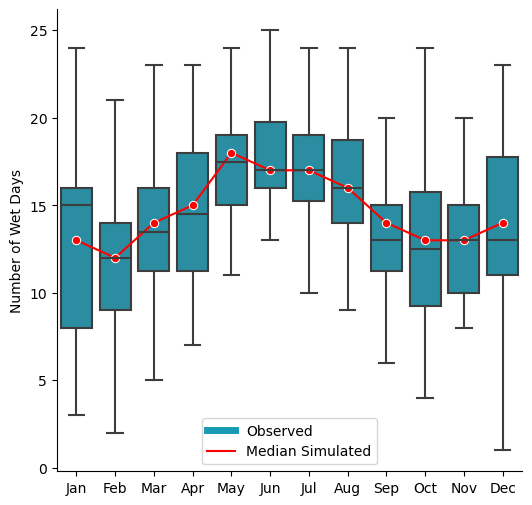

In [5]:
cs.plot_wet_days(present_data, exp_first_data, '/Users/cooper/Desktop/climate-impacts/images/wet_days.png')

### Comparing the Estimated Cumulative Distribution Function (ECDF) of the two datasets for Precipitation

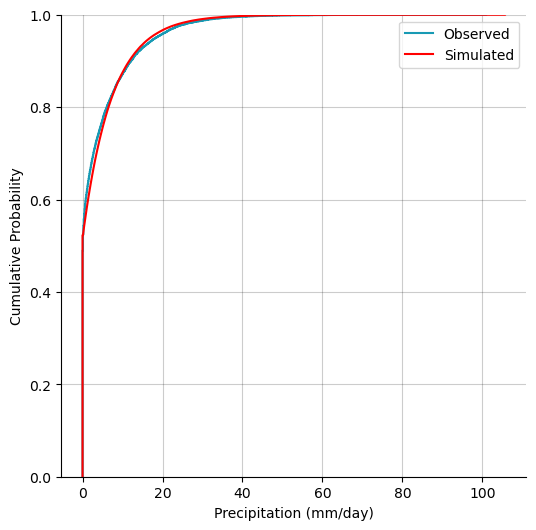

In [6]:
cs.plot_ECDF(
    observations=present_data,
    simulation=exp_first_data,
    column='Precipitation',
    xlabel='Precipitation (mm/day)',
)

### Comparing mean and standard deviation of Average Temperature values

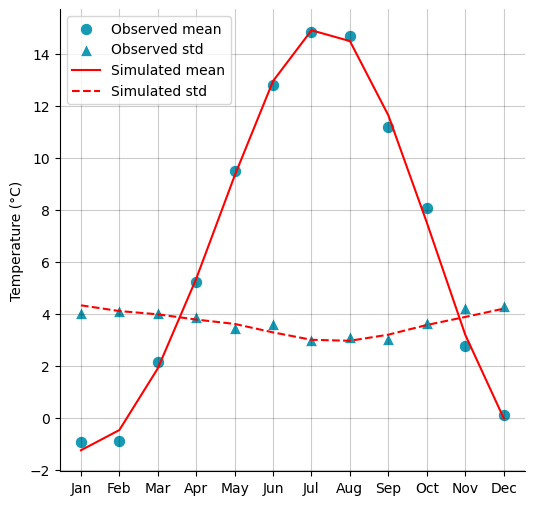

In [7]:
cs.plot_mean_and_std(
    observations=present_data,
    simulation=exp_first_data
)

### Fit an extreme parameter distribution to the generated data and to the observed data and compare the confidence intervals of the parameters

In [8]:
observed = ClimateExtreme(present_data)
generated = ClimateExtreme(exp_first_data)

In [9]:
# Cell 1: Fit GEV distribution
c, loc, scale, ci_lower, ci_upper = observed.fit_genextreme(
    "Precipitation", quantile=0.95, n_bootstrap=1000
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.5303, loc=22.1615, scale=3.8233
Confidence Intervals:
c: (-0.6168, -0.4489)
loc: (21.7740, 22.6296)
scale: (3.4927, 4.1783)


In [10]:
c, loc, scale, ci_lower, ci_upper = generated.fit_genextreme(
    "Precipitation", quantile=0.95, n_bootstrap=100
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.4909, loc=20.4388, scale=3.5739
Confidence Intervals:
c: (-0.5053, -0.4778)
loc: (20.3784, 20.4953)
scale: (3.5195, 3.6173)


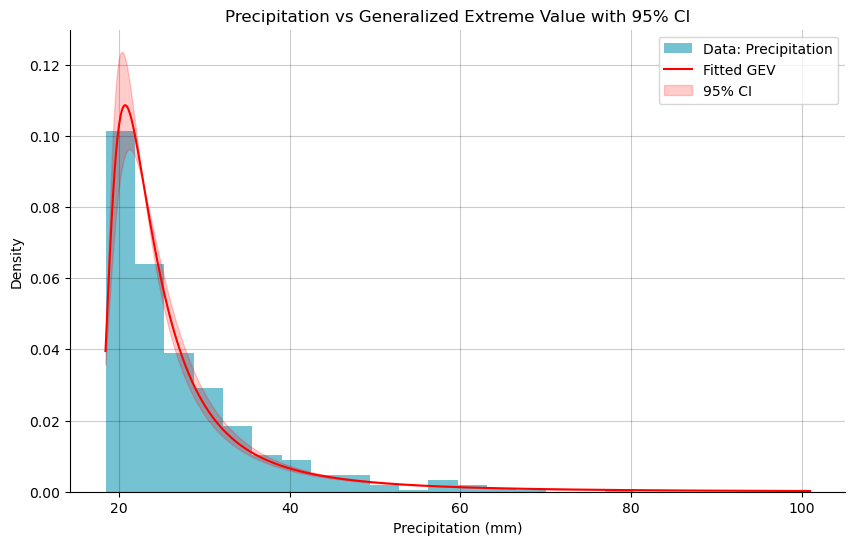

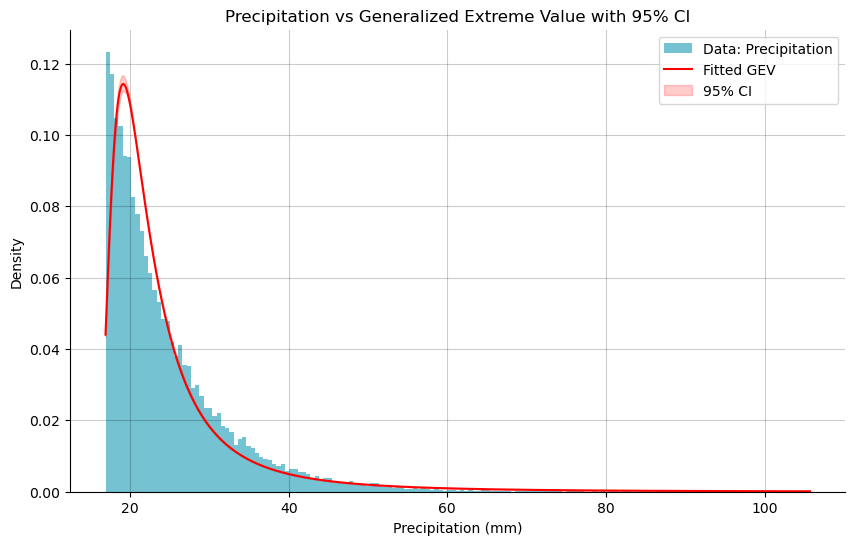

In [11]:
observed.plot_fit_and_ci("Precipitation", "mm")
generated.plot_fit_and_ci("Precipitation", "mm")

#### Compare confidence intervals

In [12]:
comparison = observed.compare_ci("Precipitation", generated, "Observed", "Generated")
print(comparison)

       Observed_value  Observed_CI_lower  Observed_CI_upper  Generated_value  \
c           -0.530303          -0.616780          -0.448911        -0.490934   
loc         22.161532          21.773976          22.629647        20.438750   
scale        3.823345           3.492708           4.178346         3.573868   

       Generated_CI_lower  Generated_CI_upper  
c               -0.505269           -0.477825  
loc             20.378402           20.495305  
scale            3.519506            3.617292  


#### Check if confidence intervals overlap

In [13]:
overlap = all(
    comparison["Observed_CI_upper"] >= comparison["Generated_CI_lower"]
) and all(comparison["Generated_CI_upper"] >= comparison["Observed_CI_lower"])

print(f"Confidence intervals {'overlap' if overlap else 'do not overlap'}")

Confidence intervals do not overlap


#### Plot the distribution for visual comparison too

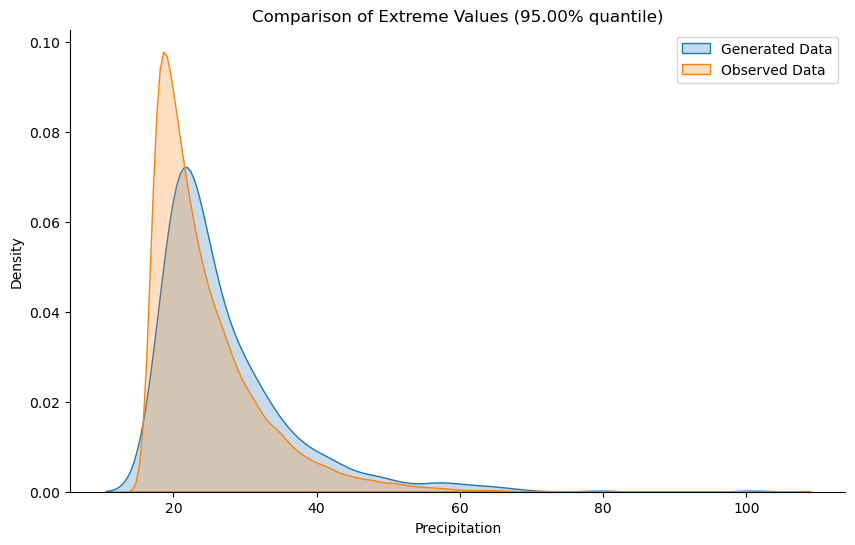

In [14]:
observed.plot_extreme_comparison('Precipitation', generated)

### Perform a Truncated 2 sample KS test

In [15]:
ks_stat, p_value = observed.truncated_ks_test('Precipitation', generated)
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")


KS statistic: 0.2753, p-value: 0.0000


### Running the Bucket Model
#### Preprocessing the data to match the format required by the Bucket Model


In [16]:
processed_present_data = preprocess_data(present_data)
processed_exp_first_data = preprocess_data(exp_first_data)

In [17]:
processed_present_data

,P_mix,T_max,T_min
date,,,
1986-01-01,0.4,1.5,-10.1
1986-01-02,5.9,4.1,-2.0
1986-01-03,0.0,4.1,-3.1
1986-01-04,7.8,-0.3,-11.7
1986-01-05,0.0,1.4,-10.1
...,...,...,...
2019-12-27,13.7,3.4,-1.1
2019-12-28,0.4,2.2,-3.6
2019-12-29,0.0,5.7,-3.2


In [18]:
processed_exp_first_data

,P_mix,T_max,T_min,Simulation
date,,,,
1980-01-01,1.052159,0.575836,-3.966348,1
1980-01-02,2.840043,2.131566,-2.196253,1
1980-01-03,0.000000,0.337740,-2.734396,1
1980-01-04,0.000000,4.614041,0.185355,1
1980-01-05,2.044771,2.277004,-3.072299,1
...,...,...,...,...
2009-12-27,13.138856,-2.289081,-9.061114,50
2009-12-28,7.726682,-2.705927,-8.001282,50
2009-12-29,5.920434,-0.570781,-7.474422,50


### Setting up the model for the catchment of Gsteig and the calibrated parameters from Assignment 2

In [19]:
bucket_model = BucketModel(
    k=0.83, S_max=12.554, fr=0.111, rg=23.587, gauge_adj=0.267
)  # Parameters from Assignment 2

bucket_model.set_catchment_properties(
    lapse_rate=0.5 / 100,  # °C/m
    station_elevation=1638,  # m.a.s.l
    basin_elevation=2035,  # m.a.s.l
    snowmelt_temp_threshold=0,  # °C
    latitude=46.9,
)  # °N

#### Running the model for the present data and visualising the results

In [20]:
results = bucket_model.run(data=processed_present_data)

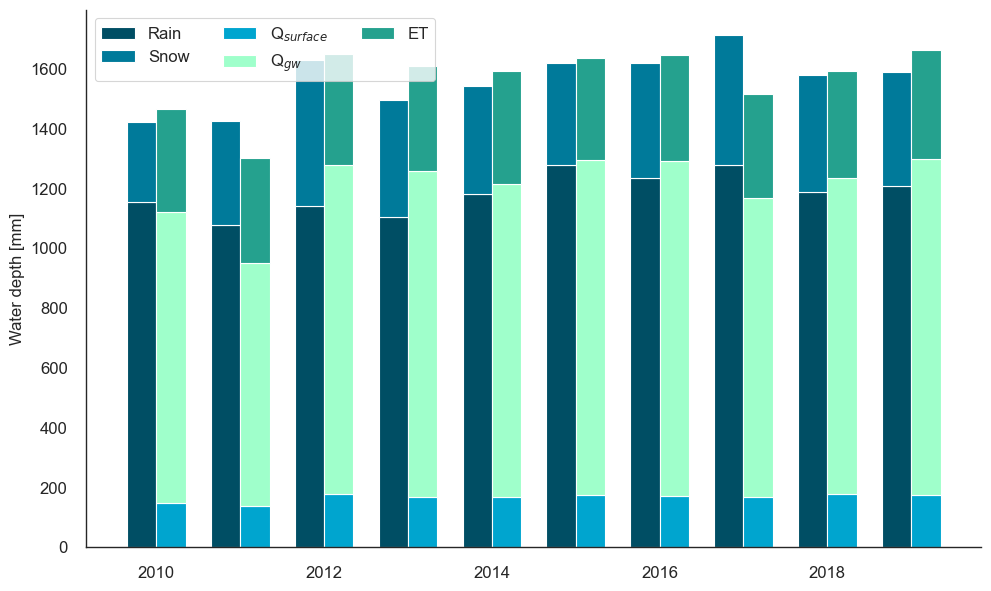

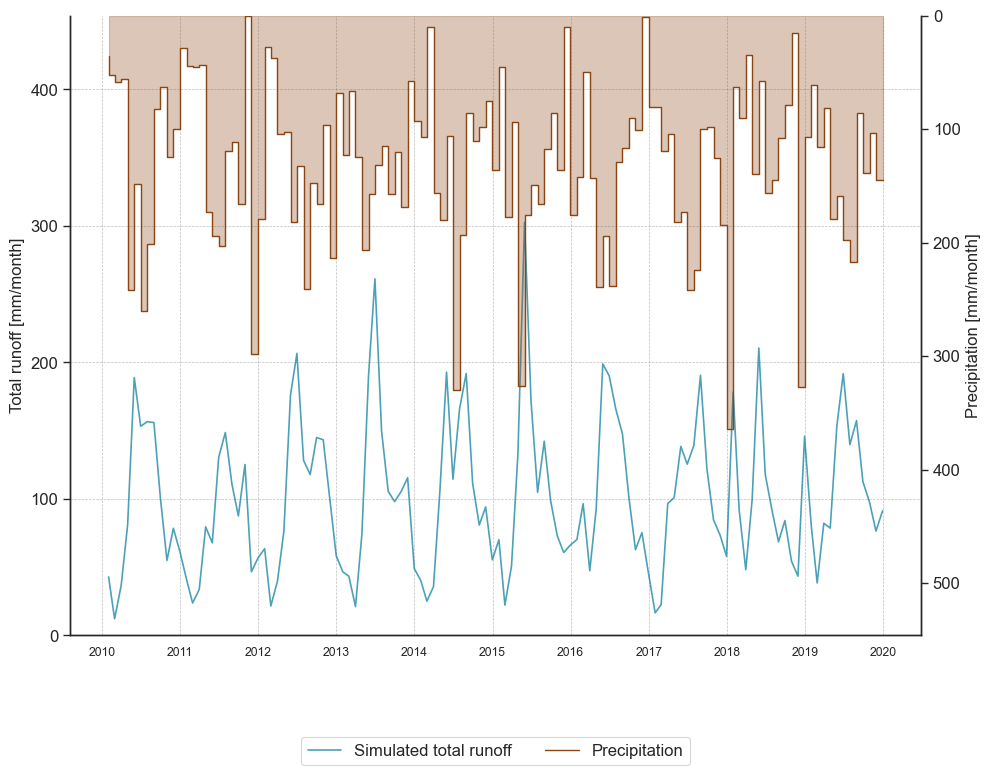

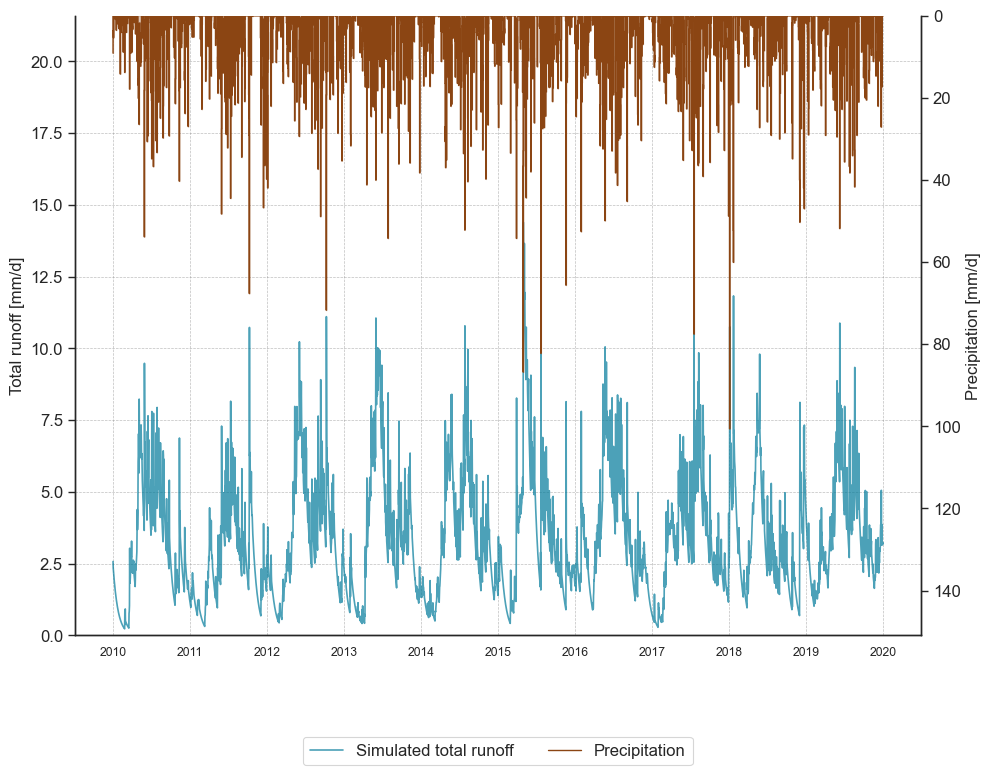

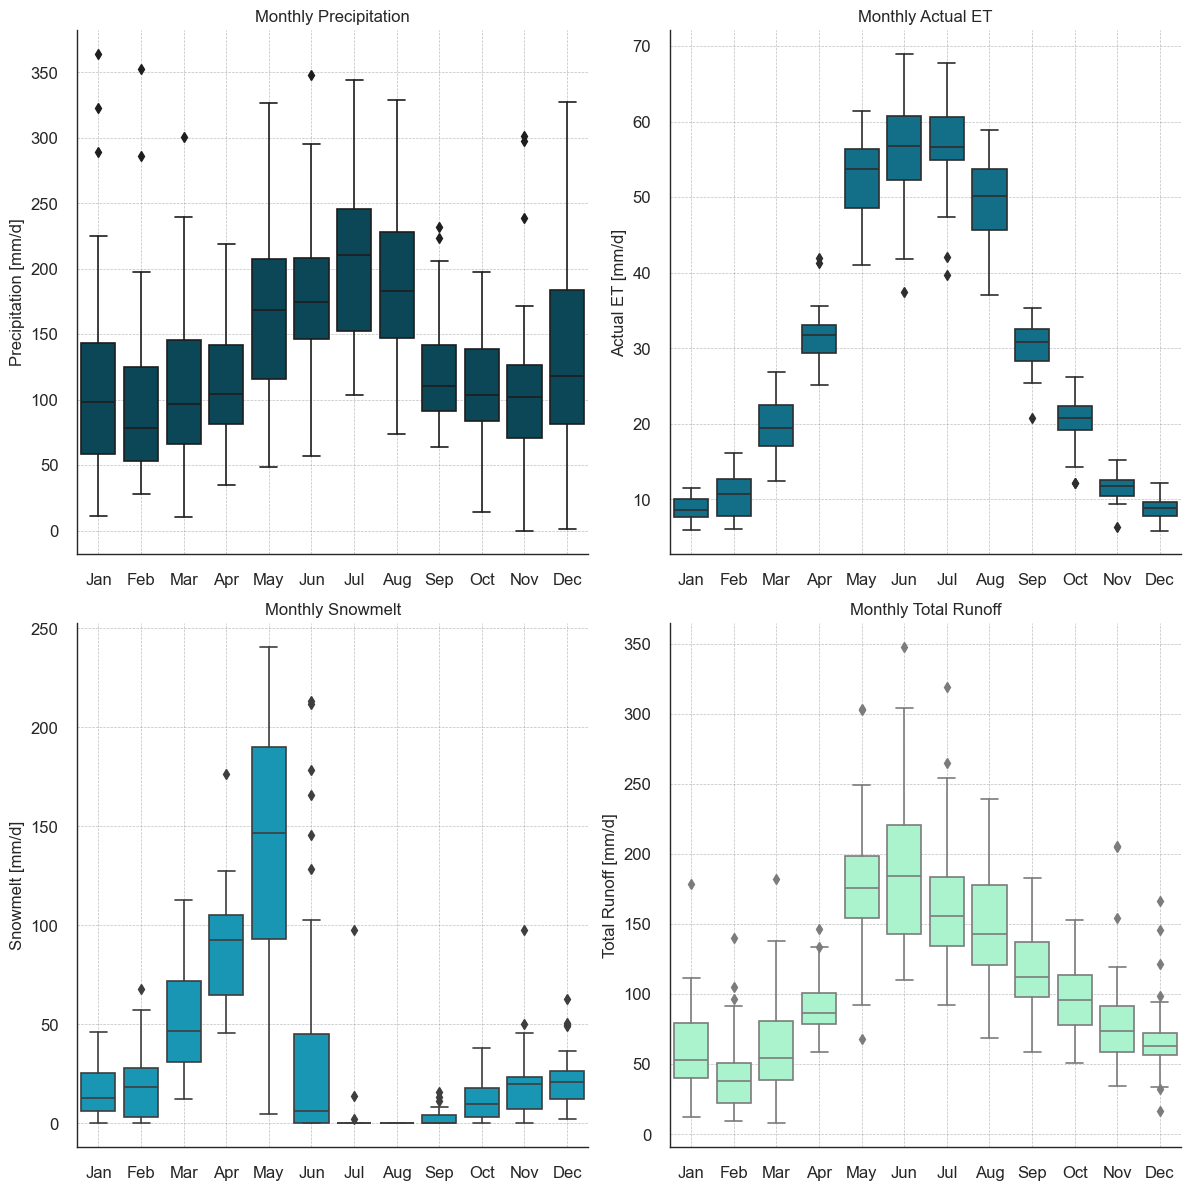

In [21]:
plot_water_balance(results=results, start_year='2010', end_year='2019')
plot_timeseries(results=results, start_year='2010', end_year='2019', monthly=True, plot_precipitation=True)
plot_timeseries(results=results, start_year='2010', end_year='2019', monthly=False, plot_precipitation=True)
plot_monthly_boxplot(results=results)

### Example of how to run the model for each Simulation individually

In [22]:
results = pd.DataFrame(columns=['ET', 'Q_s', 'Q_gw', 'Snow_accum', 'S', 'S_gw', 'Snow_melt', 'Rain',
       'Snow', 'Precip', 'Simulation'])

for simul in range(1,51):
    data = processed_exp_first_data[processed_exp_first_data['Simulation'] == simul]

    results_simul = bucket_model.run(data=data)
    results_simul['Simulation'] = simul

    results = pd.concat([results, results_simul])

results

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,Simulation
1980-01-01,0.255242,0.0,2.873608,53.402954,12.298758,64.906195,0.000000,0.000000,1.333085,1.333085,1
1980-01-02,0.282297,0.0,2.751778,56.879427,12.138322,62.154416,0.000000,0.121862,3.476473,3.598335,1
1980-01-03,0.257530,0.0,2.635113,56.879427,11.880792,59.519303,0.000000,0.000000,0.000000,0.000000,1
1980-01-04,0.325527,0.0,2.523394,56.535228,11.899465,56.995909,0.344199,0.000000,0.000000,0.000000,1
1980-01-05,0.269431,0.0,2.416412,58.984532,11.771454,54.579497,0.000000,0.141421,2.449304,2.590724,1
...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,0.185616,0.0,1.098744,85.029527,12.161509,24.817339,0.000000,0.000000,16.646930,16.646930,50
2009-12-28,0.187581,0.0,1.052162,94.819233,11.973928,23.765178,0.000000,0.000000,9.789706,9.789706,50
2009-12-29,0.204074,0.0,1.007554,102.320423,11.769855,22.757624,0.000000,0.000000,7.501190,7.501190,50
2009-12-30,0.225209,0.0,0.964838,102.320423,11.544645,21.792786,0.000000,0.000000,0.000000,0.000000,50


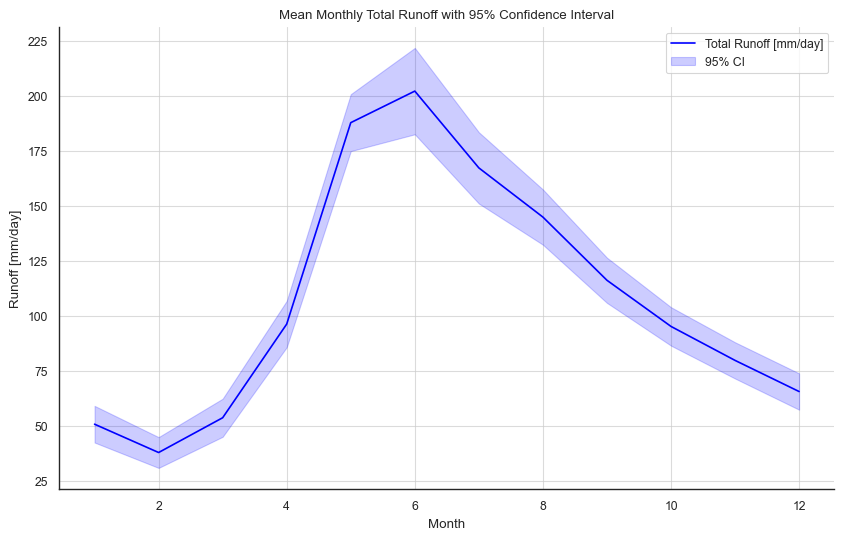

In [23]:
monthly_mean, ci = group_by_month_with_ci(results)

plot_monthly_runoff_with_ci(monthly_mean, ci)

## (Week 2) Assessing the changes to streamflow in a future climate
### Generating future climate ensembles based on delta change method

In [24]:
generate_future_climate(data=exp_first_data, name='exp_first', output_folder='/Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest')

Generating future climate data. Be patient...
Future climate data for CLMCOM-CCLM4-ECEARTH RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-ECEARTH_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-ECEARTH RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-ECEARTH_RCP8.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-HADGEM_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_CLMCOM-CCLM4-HADGEM_RCP8.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest/exp_first_DMI-HIRHAM-ECEARTH_RCP4.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureExponentialTes

### Idea to be discussed during meeting: comparing the DDFs of the present and simulated data
#### Could be fun to have the student fit the exponential to the data and then compare the parameters.

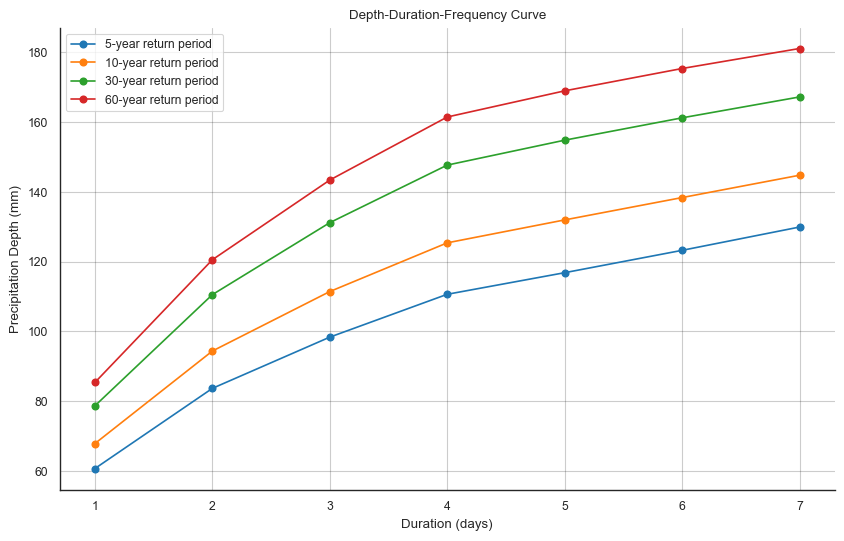

In [25]:
cs.plot_ddf(processed_present_data)